In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from data import dataloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

In [3]:
pilot_data = dataloader.break_out_blocks(
    dataloader.load_from_firebase()
)

Data loaded from Firebase!


In [4]:
for target in list(pilot_data.target.unique()):
    ib =max(
        pilot_data.loc[
            pilot_data.target==target
        ].iteration_block.dropna()
    )
    print(": ".join([
        target,
        "{0} on-target samples in {1} iteration block{2}".format(
            str(len(pilot_data.loc[
                (pilot_data.target == target) &
                (pilot_data.ontarget)
            ])),
            "%.0f" % ib,
            "s" if ib != 1 else ""
        )
    ]))


food: 322 on-target samples in 155 iteration blocks
thumb: 265 on-target samples in 156 iteration blocks
nails: 345 on-target samples in 57 iteration blocks
smoke: 435 on-target samples in 31 iteration blocks
rotate-mouth: 1212 on-target samples in 215 iteration blocks
nose: 541 on-target samples in 217 iteration blocks
rotate-nose: 1213 on-target samples in 220 iteration blocks
cheek: 950 on-target samples in 165 iteration blocks
rotate-cheek: 1207 on-target samples in 223 iteration blocks
eyebrow: 496 on-target samples in 224 iteration blocks
rotate-eyebrow: 1220 on-target samples in 227 iteration blocks
top-head: 653 on-target samples in 173 iteration blocks
rotate-top-head: 1374 on-target samples in 176 iteration blocks
back-head: 459 on-target samples in 178 iteration blocks
rotate-back-head: 1208 on-target samples in 181 iteration blocks
rotate-chin: 1216 on-target samples in 184 iteration blocks
rotate-above-ear: 1212 on-target samples in 187 iteration blocks
rotate-opposite-che

In [10]:
pilot_data

,distance,hand,ontarget,pitch,question,roll,section,step,target,thermopile1,thermopile2,thermopile3,thermopile4,timestamp,human-readable timestamp,iteration_block
0,245.0,R,False,150.0,Eat one of the items of food in front of you (...,70.0,B,1,food,76.3,80.8,85.8,81.9,1520343057446,2018-03-06 13:30:57.446,NaN
1,245.0,R,False,150.0,Eat one of the items of food in front of you (...,71.0,B,1,food,75.4,80.6,87.0,81.9,1520343057646,2018-03-06 13:30:57.646,NaN
2,245.0,R,False,150.0,Eat one of the items of food in front of you (...,69.0,B,1,food,75.4,80.9,87.0,82.4,1520343057848,2018-03-06 13:30:57.848,NaN
3,245.0,R,False,150.0,Eat one of the items of food in front of you (...,69.0,B,1,food,75.1,81.0,86.5,82.0,1520343058048,2018-03-06 13:30:58.048,NaN
4,245.0,R,False,150.0,Eat one of the items of food in front of you (...,70.0,B,1,food,75.8,80.8,86.1,81.3,1520343058247,2018-03-06 13:30:58.247,NaN
5,245.0,R,False,150.0,Eat one of the items of food in front of you (...,69.0,B,1,food,75.5,80.8,86.5,81.3,1520343058448,2018-03-06 13:30:58.448,NaN
6,243.0,R,False,150.0,Eat one of the items of food in front of you (...,70.0,B,1,food,75.5,81.3,86.5,82.3,1520343058647,2018-03-06 13:30:58.647,NaN
7,243.0,R,False,150.0,Eat one of the items of food in front of you (...,70.0,B,1,food,75.3,81.1,86.6,81.5,1520343058847,2018-03-06 13:30:58.847,NaN
8,241.0,R,False,150.0,Eat one of the items of food in front of you (...,71.0,B,1,food,75.1,81.4,86.9,81.8,1520343059048,2018-03-06 13:30:59.048,NaN
9,237.0,R,False,149.0,Eat one of the items of food in front of you (...,71.0,B,1,food,76.4,80.9,86.5,82.3,1520343059248,2018-03-06 13:30:59.248,NaN


In [12]:
# Group each target with off_target regions for training/testing

target_groupings = {'food': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'thumb': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'nails': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'smoke': ['nose', 'cheek', 'eyebrow', 'top-head'],
                    'nose': ['food', 'thumb', 'nails', 'smoke', 'cheek', 'eyebrow', 'top-head'],
                    'cheek': ['food', 'thumb', 'nails', 'smoke', 'nose', 'eyebrow', 'top-head'],
                    'eyebrow': ['food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'top-head'],
                    'top-head': ['food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'eyebrow']
                   }

In [32]:
# Separate data into on-target and off-target data

def parse_data(on_target, target_groupings):
    
    targets = ['food', 'thumb', 'nails', 'smoke', 'nose', 'cheek', 'eyebrow', 'top-head']
    off_targets = ['above-ear', 'behind-ear', 'chin', 'forehead', 'back-head', 'opposite-face', 'rotate-mouth',
                   'rotate-nose', 'rotate-cheek', 'rotate-eyebrow', 'rotate-top-head', 'rotate-back-head',
                   'rotate-chin', 'rotate-above-ear', 'rotate-opposite-cheek', 'paint-front-neck', 'paint-back-neck',
                   'paint-ear', 'paint-opposite-cheek', 'paint-top-head', 'paint-front-body', 'offbody-ceiling',
                   'offbody-floor', 'offbody-+' ,'offbody-X', 'offbody-spiral'
                  ]
    off_targets = list({*off_targets, *target_groupings[on_target]})
    
    pilot_true = []
    pilot_false = []

    for row in pilot_data[(pilot_data.target == on_target) & (pilot_data.ontarget)][['distance', 'thermopile1','thermopile2','thermopile3','thermopile4']].values.tolist():
        pilot_true.append({'in':row, 'out':1})
    for row in pilot_data[(pilot_data.target.isin(off_targets)) & (pilot_data.ontarget)][['distance', 'thermopile1', 'thermopile2', 'thermopile3', 'thermopile4']].values.tolist():
        pilot_false.append({'in':row, 'out':0})
    
    on_data = []
    on_targets = []

    for piles in pilot_true:
        on_data.append([float(x) for x in piles['in']])
        on_targets.append(piles['out'])

    off_data = []
    off_targets = []

    for piles in pilot_false:
        off_data.append([float(x) for x in piles['in']])
        off_targets.append(piles['out'])
        
    return on_data, on_targets, off_data, off_targets
    
on_data, on_targets, off_data, off_targets = parse_data('nails', target_groupings)

In [33]:
# Separate into train / test sets

def train_test(on_data, on_targets, off_data, off_targets):

    train_size_on = int(np.round(.75*len(on_data), 0))
    train_size_off = int(np.round(.75*len(off_data), 0))
    
    if train_size_on > train_size_off:
        train_size = train_size_off
    else:
        train_size = train_size_on

    train_data = []
    train_data_p = []
    test_data = []
    test_data_p = []
    train_targets = []
    test_targets = []

    train_data_p.extend(on_data[:train_size])
    train_data_p.extend(off_data[:train_size])

    for row in train_data_p:
        row = [np.round(float(x)/150,3) for x in row]
        train_data.append(row)

    test_data_p.extend(on_data[train_size:])
    test_data_p.extend(off_data[train_size:])

    for row in test_data_p:
        row = [np.round(float(x)/150,3) for x in row]
        test_data.append(row)

    train_targets.extend(on_targets[:train_size])
    train_targets.extend(off_targets[:train_size])
    test_targets.extend(on_targets[train_size:])
    test_targets.extend(off_targets[train_size:])
    
    print('Training set size: ' + str(train_size))
    
    return train_data, train_targets, test_data, test_targets

train_data, train_targets, test_data, test_targets = train_test(on_data, on_targets, off_data, off_targets)

Training set size: 259


Iteration 1, loss = 0.75374516
Iteration 2, loss = 0.75324335
Iteration 3, loss = 0.75287227
Iteration 4, loss = 0.75244901
Iteration 5, loss = 0.75194705
Iteration 6, loss = 0.75142609
Iteration 7, loss = 0.75086891
Iteration 8, loss = 0.75033352
Iteration 9, loss = 0.74983930
Iteration 10, loss = 0.74930215
Iteration 11, loss = 0.74884607
Iteration 12, loss = 0.74836574
Iteration 13, loss = 0.74787423
Iteration 14, loss = 0.74740013
Iteration 15, loss = 0.74691125
Iteration 16, loss = 0.74644982
Iteration 17, loss = 0.74597140
Iteration 18, loss = 0.74548979
Iteration 19, loss = 0.74502080
Iteration 20, loss = 0.74448839
Iteration 21, loss = 0.74396016
Iteration 22, loss = 0.74346997
Iteration 23, loss = 0.74295754
Iteration 24, loss = 0.74243304
Iteration 25, loss = 0.74189138
Iteration 26, loss = 0.74134823
Iteration 27, loss = 0.74077429
Iteration 28, loss = 0.74021155
Iteration 29, loss = 0.73971142
Iteration 30, loss = 0.73919039
Iteration 31, loss = 0.73866764
Iteration 32, los

Iteration 288, loss = 0.53315657
Iteration 289, loss = 0.53232678
Iteration 290, loss = 0.53155759
Iteration 291, loss = 0.53083810
Iteration 292, loss = 0.53003409
Iteration 293, loss = 0.52917608
Iteration 294, loss = 0.52825328
Iteration 295, loss = 0.52745294
Iteration 296, loss = 0.52677103
Iteration 297, loss = 0.52605130
Iteration 298, loss = 0.52517833
Iteration 299, loss = 0.52420401
Iteration 300, loss = 0.52374624
Iteration 301, loss = 0.52348240
Iteration 302, loss = 0.52279481
Iteration 303, loss = 0.52193421
Iteration 304, loss = 0.52096800
Iteration 305, loss = 0.52008622
Iteration 306, loss = 0.51937838
Iteration 307, loss = 0.51841597
Iteration 308, loss = 0.51766891
Iteration 309, loss = 0.51692457
Iteration 310, loss = 0.51617499
Iteration 311, loss = 0.51541019
Iteration 312, loss = 0.51465889
Iteration 313, loss = 0.51396434
Iteration 314, loss = 0.51321561
Iteration 315, loss = 0.51244537
Iteration 316, loss = 0.51163416
Iteration 317, loss = 0.51078885
Iteration 

Iteration 572, loss = 0.38592186
Iteration 573, loss = 0.38560605
Iteration 574, loss = 0.38546191
Iteration 575, loss = 0.38506665
Iteration 576, loss = 0.38470700
Iteration 577, loss = 0.38436523
Iteration 578, loss = 0.38403836
Iteration 579, loss = 0.38374698
Iteration 580, loss = 0.38348454
Iteration 581, loss = 0.38319071
Iteration 582, loss = 0.38293066
Iteration 583, loss = 0.38261088
Iteration 584, loss = 0.38252266
Iteration 585, loss = 0.38218948
Iteration 586, loss = 0.38187140
Iteration 587, loss = 0.38144743
Iteration 588, loss = 0.38108635
Iteration 589, loss = 0.38077532
Iteration 590, loss = 0.38049166
Iteration 591, loss = 0.38013339
Iteration 592, loss = 0.37979968
Iteration 593, loss = 0.37946583
Iteration 594, loss = 0.37918894
Iteration 595, loss = 0.37890846
Iteration 596, loss = 0.37862043
Iteration 597, loss = 0.37829554
Iteration 598, loss = 0.37800946
Iteration 599, loss = 0.37779267
Iteration 600, loss = 0.37739305
Iteration 601, loss = 0.37725611
Iteration 

Iteration 196, loss = 0.63320966
Iteration 197, loss = 0.63279951
Iteration 198, loss = 0.63241131
Iteration 199, loss = 0.63202782
Iteration 200, loss = 0.63161490
Iteration 201, loss = 0.63122718
Iteration 202, loss = 0.63088576
Iteration 203, loss = 0.63056107
Iteration 204, loss = 0.63018835
Iteration 205, loss = 0.62976353
Iteration 206, loss = 0.62932973
Iteration 207, loss = 0.62890007
Iteration 208, loss = 0.62847027
Iteration 209, loss = 0.62810579
Iteration 210, loss = 0.62772371
Iteration 211, loss = 0.62744526
Iteration 212, loss = 0.62717013
Iteration 213, loss = 0.62689125
Iteration 214, loss = 0.62658618
Iteration 215, loss = 0.62626153
Iteration 216, loss = 0.62591866
Iteration 217, loss = 0.62552917
Iteration 218, loss = 0.62514147
Iteration 219, loss = 0.62460710
Iteration 220, loss = 0.62396122
Iteration 221, loss = 0.62340929
Iteration 222, loss = 0.62291255
Iteration 223, loss = 0.62261272
Iteration 224, loss = 0.62227005
Iteration 225, loss = 0.62199962
Iteration 

Iteration 488, loss = 0.49544545
Iteration 489, loss = 0.49491638
Iteration 490, loss = 0.49433583
Iteration 491, loss = 0.49401446
Iteration 492, loss = 0.49351822
Iteration 493, loss = 0.49300540
Iteration 494, loss = 0.49240881
Iteration 495, loss = 0.49202628
Iteration 496, loss = 0.49151592
Iteration 497, loss = 0.49096788
Iteration 498, loss = 0.49049558
Iteration 499, loss = 0.49003678
Iteration 500, loss = 0.48963861
Iteration 501, loss = 0.48928427
Iteration 502, loss = 0.48883669
Iteration 503, loss = 0.48827256
Iteration 504, loss = 0.48776725
Iteration 505, loss = 0.48727404
Iteration 506, loss = 0.48671336
Iteration 507, loss = 0.48623424
Iteration 508, loss = 0.48575814
Iteration 509, loss = 0.48526859
Iteration 510, loss = 0.48476295
Iteration 511, loss = 0.48428247
Iteration 512, loss = 0.48386245
Iteration 513, loss = 0.48328018
Iteration 514, loss = 0.48284638
Iteration 515, loss = 0.48237359
Iteration 516, loss = 0.48184580
Iteration 517, loss = 0.48140227
Iteration 

Iteration 771, loss = 0.37913531
Iteration 772, loss = 0.37900422
Iteration 773, loss = 0.37868857
Iteration 774, loss = 0.37828290
Iteration 775, loss = 0.37796578
Iteration 776, loss = 0.37769314
Iteration 777, loss = 0.37758319
Iteration 778, loss = 0.37732518
Iteration 779, loss = 0.37702689
Iteration 780, loss = 0.37684280
Iteration 781, loss = 0.37675405
Iteration 782, loss = 0.37640306
Iteration 783, loss = 0.37596914
Iteration 784, loss = 0.37563672
Iteration 785, loss = 0.37531739
Iteration 786, loss = 0.37495883
Iteration 787, loss = 0.37455732
Iteration 788, loss = 0.37425789
Iteration 789, loss = 0.37396405
Iteration 790, loss = 0.37384350
Iteration 791, loss = 0.37357545
Iteration 792, loss = 0.37324029
Iteration 793, loss = 0.37292022
Iteration 794, loss = 0.37260646
Iteration 795, loss = 0.37223011
Iteration 796, loss = 0.37195376
Iteration 797, loss = 0.37167198
Iteration 798, loss = 0.37151308
Iteration 799, loss = 0.37125457
Iteration 800, loss = 0.37086416
Iteration 

Iteration 207, loss = 0.55951394
Iteration 208, loss = 0.55915722
Iteration 209, loss = 0.55882511
Iteration 210, loss = 0.55847969
Iteration 211, loss = 0.55810798
Iteration 212, loss = 0.55778134
Iteration 213, loss = 0.55741731
Iteration 214, loss = 0.55706442
Iteration 215, loss = 0.55669874
Iteration 216, loss = 0.55632684
Iteration 217, loss = 0.55593807
Iteration 218, loss = 0.55557007
Iteration 219, loss = 0.55522519
Iteration 220, loss = 0.55490009
Iteration 221, loss = 0.55455963
Iteration 222, loss = 0.55420566
Iteration 223, loss = 0.55383287
Iteration 224, loss = 0.55347744
Iteration 225, loss = 0.55311893
Iteration 226, loss = 0.55276845
Iteration 227, loss = 0.55242386
Iteration 228, loss = 0.55207504
Iteration 229, loss = 0.55177855
Iteration 230, loss = 0.55145882
Iteration 231, loss = 0.55116296
Iteration 232, loss = 0.55085001
Iteration 233, loss = 0.55056460
Iteration 234, loss = 0.55027582
Iteration 235, loss = 0.54999701
Iteration 236, loss = 0.54972057
Iteration 

Iteration 500, loss = 0.51204459
Iteration 501, loss = 0.51197956
Iteration 502, loss = 0.51191462
Iteration 503, loss = 0.51185862
Iteration 504, loss = 0.51180465
Iteration 505, loss = 0.51178709
Iteration 506, loss = 0.51171596
Iteration 507, loss = 0.51168544
Iteration 508, loss = 0.51166123
Iteration 509, loss = 0.51162904
Iteration 510, loss = 0.51158940
Iteration 511, loss = 0.51153282
Iteration 512, loss = 0.51158637
Iteration 513, loss = 0.51154661
Iteration 514, loss = 0.51139423
Iteration 515, loss = 0.51126496
Iteration 516, loss = 0.51126264
Iteration 517, loss = 0.51122015
Iteration 518, loss = 0.51117852
Iteration 519, loss = 0.51112648
Iteration 520, loss = 0.51107362
Iteration 521, loss = 0.51101192
Iteration 522, loss = 0.51095208
Iteration 523, loss = 0.51089055
Iteration 524, loss = 0.51086041
Iteration 525, loss = 0.51081821
Iteration 526, loss = 0.51077064
Iteration 527, loss = 0.51072528
Iteration 528, loss = 0.51066703
Iteration 529, loss = 0.51061463
Iteration 

Iteration 198, loss = 0.44063291
Iteration 199, loss = 0.43921379
Iteration 200, loss = 0.43739066
Iteration 201, loss = 0.43563835
Iteration 202, loss = 0.43434111
Iteration 203, loss = 0.43315055
Iteration 204, loss = 0.43283852
Iteration 205, loss = 0.43170288
Iteration 206, loss = 0.43082925
Iteration 207, loss = 0.42962031
Iteration 208, loss = 0.42824323
Iteration 209, loss = 0.42703428
Iteration 210, loss = 0.42585536
Iteration 211, loss = 0.42428478
Iteration 212, loss = 0.42287844
Iteration 213, loss = 0.42160056
Iteration 214, loss = 0.42046967
Iteration 215, loss = 0.41920706
Iteration 216, loss = 0.41800522
Iteration 217, loss = 0.41687010
Iteration 218, loss = 0.41571998
Iteration 219, loss = 0.41469953
Iteration 220, loss = 0.41366957
Iteration 221, loss = 0.41260732
Iteration 222, loss = 0.41142057
Iteration 223, loss = 0.41013451
Iteration 224, loss = 0.40906646
Iteration 225, loss = 0.40798172
Iteration 226, loss = 0.40698789
Iteration 227, loss = 0.40604272
Iteration 

Iteration 101, loss = 0.52295163
Iteration 102, loss = 0.52128815
Iteration 103, loss = 0.51954429
Iteration 104, loss = 0.51776375
Iteration 105, loss = 0.51598345
Iteration 106, loss = 0.51423179
Iteration 107, loss = 0.51257543
Iteration 108, loss = 0.51092919
Iteration 109, loss = 0.50940408
Iteration 110, loss = 0.50779718
Iteration 111, loss = 0.50620562
Iteration 112, loss = 0.50470901
Iteration 113, loss = 0.50318989
Iteration 114, loss = 0.50164138
Iteration 115, loss = 0.50009235
Iteration 116, loss = 0.49860188
Iteration 117, loss = 0.49703093
Iteration 118, loss = 0.49549044
Iteration 119, loss = 0.49390889
Iteration 120, loss = 0.49259888
Iteration 121, loss = 0.49118692
Iteration 122, loss = 0.48993665
Iteration 123, loss = 0.48855133
Iteration 124, loss = 0.48698784
Iteration 125, loss = 0.48534120
Iteration 126, loss = 0.48392519
Iteration 127, loss = 0.48255965
Iteration 128, loss = 0.48104502
Iteration 129, loss = 0.47947937
Iteration 130, loss = 0.47806570
Iteration 

Iteration 395, loss = 0.29280196
Iteration 396, loss = 0.29258607
Iteration 397, loss = 0.29242179
Iteration 398, loss = 0.29220794
Iteration 399, loss = 0.29215038
Iteration 400, loss = 0.29173203
Iteration 401, loss = 0.29158087
Iteration 402, loss = 0.29131617
Iteration 403, loss = 0.29108156
Iteration 404, loss = 0.29095812
Iteration 405, loss = 0.29105731
Iteration 406, loss = 0.29090308
Iteration 407, loss = 0.29069651
Iteration 408, loss = 0.29029865
Iteration 409, loss = 0.29006484
Iteration 410, loss = 0.28993529
Iteration 411, loss = 0.28968320
Iteration 412, loss = 0.28957658
Iteration 413, loss = 0.28923773
Iteration 414, loss = 0.28876684
Iteration 415, loss = 0.28853209
Iteration 416, loss = 0.28864994
Iteration 417, loss = 0.28875446
Iteration 418, loss = 0.28893084
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
0.527055227113
Iteration 1, loss = 0.90147536
Iteration 2, loss = 0.89522644
Iteration 3, loss = 0.88887449
Iteration

Iteration 295, loss = 0.48277981
Iteration 296, loss = 0.48137315
Iteration 297, loss = 0.48008369
Iteration 298, loss = 0.47894102
Iteration 299, loss = 0.47775983
Iteration 300, loss = 0.47665694
Iteration 301, loss = 0.47550402
Iteration 302, loss = 0.47432845
Iteration 303, loss = 0.47317438
Iteration 304, loss = 0.47210496
Iteration 305, loss = 0.47160916
Iteration 306, loss = 0.47073897
Iteration 307, loss = 0.46975944
Iteration 308, loss = 0.46887922
Iteration 309, loss = 0.46770749
Iteration 310, loss = 0.46613580
Iteration 311, loss = 0.46476522
Iteration 312, loss = 0.46344373
Iteration 313, loss = 0.46240752
Iteration 314, loss = 0.46135999
Iteration 315, loss = 0.46023443
Iteration 316, loss = 0.45921475
Iteration 317, loss = 0.45812071
Iteration 318, loss = 0.45698787
Iteration 319, loss = 0.45596398
Iteration 320, loss = 0.45489327
Iteration 321, loss = 0.45378162
Iteration 322, loss = 0.45241915
Iteration 323, loss = 0.45106609
Iteration 324, loss = 0.45015116
Iteration 

Iteration 98, loss = 0.66062258
Iteration 99, loss = 0.66027328
Iteration 100, loss = 0.65991562
Iteration 101, loss = 0.65956308
Iteration 102, loss = 0.65921456
Iteration 103, loss = 0.65889798
Iteration 104, loss = 0.65855810
Iteration 105, loss = 0.65824041
Iteration 106, loss = 0.65793002
Iteration 107, loss = 0.65762675
Iteration 108, loss = 0.65730017
Iteration 109, loss = 0.65698536
Iteration 110, loss = 0.65664257
Iteration 111, loss = 0.65629373
Iteration 112, loss = 0.65594095
Iteration 113, loss = 0.65559068
Iteration 114, loss = 0.65523215
Iteration 115, loss = 0.65485207
Iteration 116, loss = 0.65448754
Iteration 117, loss = 0.65410571
Iteration 118, loss = 0.65370391
Iteration 119, loss = 0.65333103
Iteration 120, loss = 0.65294191
Iteration 121, loss = 0.65259288
Iteration 122, loss = 0.65223070
Iteration 123, loss = 0.65187520
Iteration 124, loss = 0.65154125
Iteration 125, loss = 0.65116766
Iteration 126, loss = 0.65079237
Iteration 127, loss = 0.65042186
Iteration 12

Iteration 377, loss = 0.55241039
Iteration 378, loss = 0.55217498
Iteration 379, loss = 0.55191974
Iteration 380, loss = 0.55167512
Iteration 381, loss = 0.55144007
Iteration 382, loss = 0.55121392
Iteration 383, loss = 0.55098666
Iteration 384, loss = 0.55074169
Iteration 385, loss = 0.55048426
Iteration 386, loss = 0.55023852
Iteration 387, loss = 0.54998781
Iteration 388, loss = 0.54974251
Iteration 389, loss = 0.54949127
Iteration 390, loss = 0.54923882
Iteration 391, loss = 0.54900530
Iteration 392, loss = 0.54876134
Iteration 393, loss = 0.54851322
Iteration 394, loss = 0.54827896
Iteration 395, loss = 0.54803107
Iteration 396, loss = 0.54779326
Iteration 397, loss = 0.54755535
Iteration 398, loss = 0.54731279
Iteration 399, loss = 0.54707488
Iteration 400, loss = 0.54683881
Iteration 401, loss = 0.54658205
Iteration 402, loss = 0.54634035
Iteration 403, loss = 0.54608116
Iteration 404, loss = 0.54584667
Iteration 405, loss = 0.54562350
Iteration 406, loss = 0.54539174
Iteration 

Iteration 654, loss = 0.51730803
Iteration 655, loss = 0.51725700
Iteration 656, loss = 0.51721400
Iteration 657, loss = 0.51726281
Iteration 658, loss = 0.51734833
Iteration 659, loss = 0.51719914
Iteration 660, loss = 0.51702559
Iteration 661, loss = 0.51695028
Iteration 662, loss = 0.51689908
Iteration 663, loss = 0.51686184
Iteration 664, loss = 0.51681930
Iteration 665, loss = 0.51678028
Iteration 666, loss = 0.51673872
Iteration 667, loss = 0.51669948
Iteration 668, loss = 0.51665216
Iteration 669, loss = 0.51661115
Iteration 670, loss = 0.51656788
Iteration 671, loss = 0.51652803
Iteration 672, loss = 0.51649111
Iteration 673, loss = 0.51646368
Iteration 674, loss = 0.51641551
Iteration 675, loss = 0.51637627
Iteration 676, loss = 0.51632972
Iteration 677, loss = 0.51628303
Iteration 678, loss = 0.51624034
Iteration 679, loss = 0.51619794
Iteration 680, loss = 0.51616523
Iteration 681, loss = 0.51612788
Iteration 682, loss = 0.51609133
Iteration 683, loss = 0.51605579
Iteration 

Iteration 193, loss = 0.60871522
Iteration 194, loss = 0.60756179
Iteration 195, loss = 0.60643098
Iteration 196, loss = 0.60529406
Iteration 197, loss = 0.60410032
Iteration 198, loss = 0.60283000
Iteration 199, loss = 0.60165455
Iteration 200, loss = 0.60050913
Iteration 201, loss = 0.59936889
Iteration 202, loss = 0.59835469
Iteration 203, loss = 0.59719672
Iteration 204, loss = 0.59596583
Iteration 205, loss = 0.59478356
Iteration 206, loss = 0.59360121
Iteration 207, loss = 0.59243389
Iteration 208, loss = 0.59129553
Iteration 209, loss = 0.59015406
Iteration 210, loss = 0.58901710
Iteration 211, loss = 0.58784606
Iteration 212, loss = 0.58668995
Iteration 213, loss = 0.58550560
Iteration 214, loss = 0.58428329
Iteration 215, loss = 0.58310709
Iteration 216, loss = 0.58191899
Iteration 217, loss = 0.58082644
Iteration 218, loss = 0.57964961
Iteration 219, loss = 0.57852578
Iteration 220, loss = 0.57750146
Iteration 221, loss = 0.57636330
Iteration 222, loss = 0.57532565
Iteration 

Iteration 472, loss = 0.41486084
Iteration 473, loss = 0.41436035
Iteration 474, loss = 0.41395455
Iteration 475, loss = 0.41353325
Iteration 476, loss = 0.41312916
Iteration 477, loss = 0.41266530
Iteration 478, loss = 0.41230917
Iteration 479, loss = 0.41189282
Iteration 480, loss = 0.41153155
Iteration 481, loss = 0.41119040
Iteration 482, loss = 0.41078974
Iteration 483, loss = 0.41043116
Iteration 484, loss = 0.41003377
Iteration 485, loss = 0.40966681
Iteration 486, loss = 0.40922808
Iteration 487, loss = 0.40880108
Iteration 488, loss = 0.40834155
Iteration 489, loss = 0.40794019
Iteration 490, loss = 0.40752723
Iteration 491, loss = 0.40720432
Iteration 492, loss = 0.40689622
Iteration 493, loss = 0.40658209
Iteration 494, loss = 0.40624409
Iteration 495, loss = 0.40581093
Iteration 496, loss = 0.40534542
Iteration 497, loss = 0.40491240
Iteration 498, loss = 0.40445693
Iteration 499, loss = 0.40406893
Iteration 500, loss = 0.40361884
Iteration 501, loss = 0.40321303
Iteration 

Iteration 197, loss = 0.71250901
Iteration 198, loss = 0.71232226
Iteration 199, loss = 0.71214839
Iteration 200, loss = 0.71195540
Iteration 201, loss = 0.71176824
Iteration 202, loss = 0.71159025
Iteration 203, loss = 0.71137150
Iteration 204, loss = 0.71119213
Iteration 205, loss = 0.71098216
Iteration 206, loss = 0.71082403
Iteration 207, loss = 0.71067065
Iteration 208, loss = 0.71051268
Iteration 209, loss = 0.71033458
Iteration 210, loss = 0.71016111
Iteration 211, loss = 0.70998687
Iteration 212, loss = 0.70982350
Iteration 213, loss = 0.70965173
Iteration 214, loss = 0.70946898
Iteration 215, loss = 0.70932580
Iteration 216, loss = 0.70914332
Iteration 217, loss = 0.70894176
Iteration 218, loss = 0.70877571
Iteration 219, loss = 0.70861777
Iteration 220, loss = 0.70845944
Iteration 221, loss = 0.70832029
Iteration 222, loss = 0.70817055
Iteration 223, loss = 0.70803247
Iteration 224, loss = 0.70788827
Iteration 225, loss = 0.70775750
Iteration 226, loss = 0.70763411
Iteration 

Iteration 482, loss = 0.52425882
Iteration 483, loss = 0.52370133
Iteration 484, loss = 0.52311963
Iteration 485, loss = 0.52241168
Iteration 486, loss = 0.52173383
Iteration 487, loss = 0.52110028
Iteration 488, loss = 0.52040882
Iteration 489, loss = 0.51963698
Iteration 490, loss = 0.51888330
Iteration 491, loss = 0.51827413
Iteration 492, loss = 0.51767246
Iteration 493, loss = 0.51735991
Iteration 494, loss = 0.51653639
Iteration 495, loss = 0.51551880
Iteration 496, loss = 0.51494220
Iteration 497, loss = 0.51443740
Iteration 498, loss = 0.51380578
Iteration 499, loss = 0.51305580
Iteration 500, loss = 0.51237265
Iteration 501, loss = 0.51165272
Iteration 502, loss = 0.51098566
Iteration 503, loss = 0.51033239
Iteration 504, loss = 0.50970946
Iteration 505, loss = 0.50913030
Iteration 506, loss = 0.50848718
Iteration 507, loss = 0.50775639
Iteration 508, loss = 0.50709027
Iteration 509, loss = 0.50649328
Iteration 510, loss = 0.50584444
Iteration 511, loss = 0.50522892
Iteration 

Iteration 93, loss = 0.58872293
Iteration 94, loss = 0.58807024
Iteration 95, loss = 0.58721078
Iteration 96, loss = 0.58642115
Iteration 97, loss = 0.58557977
Iteration 98, loss = 0.58474642
Iteration 99, loss = 0.58395118
Iteration 100, loss = 0.58312003
Iteration 101, loss = 0.58228906
Iteration 102, loss = 0.58144012
Iteration 103, loss = 0.58058902
Iteration 104, loss = 0.57969747
Iteration 105, loss = 0.57882031
Iteration 106, loss = 0.57795071
Iteration 107, loss = 0.57710209
Iteration 108, loss = 0.57615947
Iteration 109, loss = 0.57523345
Iteration 110, loss = 0.57431028
Iteration 111, loss = 0.57335269
Iteration 112, loss = 0.57248321
Iteration 113, loss = 0.57157786
Iteration 114, loss = 0.57071902
Iteration 115, loss = 0.56982169
Iteration 116, loss = 0.56901367
Iteration 117, loss = 0.56811931
Iteration 118, loss = 0.56722698
Iteration 119, loss = 0.56629572
Iteration 120, loss = 0.56531641
Iteration 121, loss = 0.56432187
Iteration 122, loss = 0.56337068
Iteration 123, lo

Iteration 373, loss = 0.39007030
Iteration 374, loss = 0.38965425
Iteration 375, loss = 0.38915407
Iteration 376, loss = 0.38870010
Iteration 377, loss = 0.38819461
Iteration 378, loss = 0.38844824
Iteration 379, loss = 0.38786998
Iteration 380, loss = 0.38718570
Iteration 381, loss = 0.38672773
Iteration 382, loss = 0.38638759
Iteration 383, loss = 0.38593782
Iteration 384, loss = 0.38537875
Iteration 385, loss = 0.38480827
Iteration 386, loss = 0.38441872
Iteration 387, loss = 0.38408475
Iteration 388, loss = 0.38395034
Iteration 389, loss = 0.38381873
Iteration 390, loss = 0.38324766
Iteration 391, loss = 0.38272441
Iteration 392, loss = 0.38221302
Iteration 393, loss = 0.38166574
Iteration 394, loss = 0.38107546
Iteration 395, loss = 0.38067373
Iteration 396, loss = 0.38026690
Iteration 397, loss = 0.37987248
Iteration 398, loss = 0.37946964
Iteration 399, loss = 0.37918841
Iteration 400, loss = 0.37932239
Iteration 401, loss = 0.37889194
Iteration 402, loss = 0.37823970
Iteration 

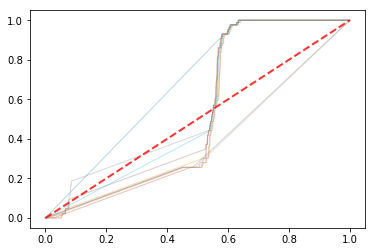

Summary statistics after 10 iterations:
True positive rate:  0.831
False positive rate: 0.169
True negative rate:  0.418
False negative rate: 0.582


In [44]:
from sklearn.metrics import roc_curve, auc

def nn_iterations(train_data, train_targets, test_data, test_targets, iterations=100):
    
    true_pos_sum = []
    true_neg_sum = []
    fals_pos_sum = []
    fals_neg_sum = []
    sum_stats = []
    
    plt.figure()
    
    for num in range(iterations):
        
        clf = MLPClassifier(solver='adam', alpha=.0001,
                            hidden_layer_sizes=(5,2),
                            max_iter=5000, verbose=True,
                            tol=.00001, batch_size=250)
        clf.fit(train_data, train_targets)
        
        num_predict = len(test_data)

        predictions = clf.predict(test_data[:num_predict])
        predi_probs = clf.predict_proba(test_data[:num_predict])
        fpr, tpr, thresholds = roc_curve(test_targets, predi_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold (AUC = %0.2f)' % (roc_auc))
        predi_fals = [x for x,y in predi_probs]
        predi_true = [y for x,y in predi_probs]
        
        for item in range(len(predictions)):
            
            if predictions[item] == test_targets[item]:
                pred = 'correct'
            else:
                pred = 'incorrect'
            
            sum_stats.append({str(num + 1): [test_targets[item], predictions[item], predi_probs[item][0], predi_probs[item][1], pred]})

        count_neg = len([x for x in test_targets if x == 0])
        count_pos = len([x for x in test_targets if x == 1])
        
        true_pos = []
        true_neg = []
        fals_pos = []
        fals_neg = []

        for sample in range(len(test_data)):
            if test_targets[sample] == 0:
                if predictions[sample] == test_targets[sample]:
                    true_neg.append(sample)
                else:
                    fals_neg.append(sample)
            elif test_targets[sample] == 1:
                if predictions[sample] == test_targets[sample]:
                    true_pos.append(sample)
                else:
                    fals_pos.append(sample)

        fals_pos_sum.append(str(len(fals_pos)/count_pos))
        fals_neg_sum.append(str(len(fals_neg)/count_neg))
        true_pos_sum.append(str(len(true_pos)/count_pos))
        true_neg_sum.append(str(len(true_neg)/count_neg))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    plt.show()
    
    fals_pos_sum = [float(x) for x in fals_pos_sum]
    fals_neg_sum = [float(x) for x in fals_neg_sum]
    true_pos_sum = [float(x) for x in true_pos_sum]
    true_neg_sum = [float(x) for x in true_neg_sum]
        
    fals_pos_sum = np.average(np.array(fals_pos_sum))
    fals_neg_sum = np.average(np.array(fals_neg_sum))
    true_pos_sum = np.average(np.array(true_pos_sum))
    true_neg_sum = np.average(np.array(true_neg_sum))

    print('Summary statistics after ' + str(iterations) + ' iterations:')
    print('True positive rate:  ' + str(np.round(true_pos_sum,3)))
    print('False positive rate: ' + str(np.round(fals_pos_sum,3)))
    print('True negative rate:  ' + str(np.round(true_neg_sum,3)))
    print('False negative rate: ' + str(np.round(fals_neg_sum,3)))
    
    return predi_probs, sum_stats
    
predi_probs, sum_stats = nn_iterations(train_data, train_targets, test_data, test_targets, iterations=10)